<a href="https://colab.research.google.com/github/grace-arina/Diagnosing-Pneumonia_CNN/blob/final-notebook/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia

In [1]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing necessary dependencies 
import pandas as pd
import numpy as np
np.random.seed(123)
import datetime

import scipy
import os, shutil
from PIL import Image
from scipy import ndimage


import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, SeparableConv2D , BatchNormalization,Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.callbacks import EarlyStopping, ModelCheckpoint, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')


import warnings
warnings.filterwarnings('ignore')

%load_ext tensorboard

## Setting up models with Tensorflow 2.5
Version capped at Tensorflow 2.5 to use local GPU

In [3]:
#Loading files and recaling images
idg = ImageDataGenerator(rescale=1./255)

train_set = idg.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/train',
                                                 target_size=(150, 150),
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 color_mode='grayscale')

val_set = idg.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/val',
                                          target_size=(150, 150),
                                          batch_size=32,
                                          class_mode='binary',
                                          color_mode='grayscale')

test_set = idg.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/test',
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='binary',
                                            color_mode='grayscale')

Found 5022 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Setting up Baseline Model

In [8]:
# Setting paramaters on early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          patience=20,
                          verbose=1,
                          mode='min',
                          restore_best_weights=True)

#If recreating notebook, use the below 3 lines of code to save a checkpoint for your models, where your logs should be saved and the Tensorboard callback to save your models in Tensorboard

# mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model1.h5",monitor= "val_loss", save_best_only=True )
# log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/"
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
#Setting up a baseline model
model1 = models.Sequential()

#1st Layer
model1.add(layers.Conv2D(32, 7, input_shape=(150,150,1), padding='same',activation='relu'))
model1.add(layers.MaxPooling2D(2))

#2nd layer
model1.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model1.add(layers.MaxPooling2D(2))

#Flattening data into 1 vector
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(32, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

#Compiling model with adam optemizer, binary_crossentropy since this is binairy classification and setting metrics to accuracy and recall
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.metrics.Recall()])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      1600      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 87616)             0         
                                                                 
 dense_3 (Dense)             (None, 64)               

In [14]:
#Fitting model, with 100 steps and 30 epochs and using early stop when our model stops improving
history1 = model1.fit(train_set,
                    validation_data=val_set,
                    steps_per_epoch=100,
                    epochs=30,
                    callbacks=[earlystop])

Epoch 1/30
100/100 [==============================] - 49s 480ms/step - loss: 0.2441 - acc: 0.9006 - recall_1: 0.9575 - val_loss: 0.1542 - val_acc: 0.9429 - val_recall_1: 0.9276
Epoch 2/30
100/100 [==============================] - 48s 477ms/step - loss: 0.1079 - acc: 0.9600 - recall_1: 0.9759 - val_loss: 0.0965 - val_acc: 0.9714 - val_recall_1: 0.9671
Epoch 3/30
100/100 [==============================] - 49s 488ms/step - loss: 0.0983 - acc: 0.9669 - recall_1: 0.9775 - val_loss: 0.1228 - val_acc: 0.9429 - val_recall_1: 0.9868
Epoch 4/30
100/100 [==============================] - 49s 484ms/step - loss: 0.0815 - acc: 0.9694 - recall_1: 0.9805 - val_loss: 0.1253 - val_acc: 0.9476 - val_recall_1: 0.9868
Epoch 5/30
100/100 [==============================] - 45s 446ms/step - loss: 0.0702 - acc: 0.9716 - recall_1: 0.9833 - val_loss: 0.1039 - val_acc: 0.9571 - val_recall_1: 0.9474
Epoch 6/30
100/100 [==============================] - 45s 449ms/step - loss: 0.0587 - acc: 0.9791 - recall_1: 0.986

In [15]:
#Evaluating model on test data
model1.evaluate(test_set)

20/20 [==============================] - 94s 5s/step - loss: 4.0147 - acc: 0.7308 - recall_1: 0.9949


[4.014666557312012, 0.7307692170143127, 0.9948717951774597]

## Second Model With Image Augmentation

In [16]:
# This is the same as the best previous model with image augmentation
augment_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=.2,
                                   height_shift_range=.2,
                                   shear_range=.2,
                                   zoom_range=.2,
                                   brightness_range=[.5, 1.5])

augment_set = augment_gen.flow_from_directory('/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/train',
                                                 target_size=(150, 150),
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 color_mode='grayscale')

augmented = models.Sequential()

augmented.add(layers.Conv2D(32, 7, padding='valid', input_shape=(150,150,1), activation='relu'))
augmented.add(layers.MaxPooling2D(2))

augmented.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
augmented.add(layers.MaxPooling2D(2))

augmented.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
augmented.add(layers.MaxPooling2D(3))

augmented.add(layers.Flatten())
augmented.add(layers.Dense(64, activation='relu'))
augmented.add(layers.Dense(1, activation='sigmoid'))

augmented.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.metrics.Recall()])

augmented.summary()

Found 5022 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 144, 144, 32)      1600      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 72, 72, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 36, 36, 64)        36928     
                                                                 
 max_pooling

In [17]:
historyaug = augmented.fit(augment_set,
                    validation_data=val_set,
                    steps_per_epoch=100,
                    epochs=30,
                    callbacks=[earlystop])

Epoch 1/30
100/100 [==============================] - 61s 580ms/step - loss: 0.5348 - acc: 0.7419 - recall_2: 0.9395 - val_loss: 0.4802 - val_acc: 0.7429 - val_recall_2: 0.9539
Epoch 2/30
100/100 [==============================] - 60s 599ms/step - loss: 0.4535 - acc: 0.7649 - recall_2: 0.8573 - val_loss: 0.4251 - val_acc: 0.7381 - val_recall_2: 0.9934
Epoch 3/30
100/100 [==============================] - 57s 569ms/step - loss: 0.4131 - acc: 0.7919 - recall_2: 0.8869 - val_loss: 0.3370 - val_acc: 0.7952 - val_recall_2: 0.9013
Epoch 4/30
100/100 [==============================] - 56s 564ms/step - loss: 0.3737 - acc: 0.8184 - recall_2: 0.9047 - val_loss: 0.3180 - val_acc: 0.8619 - val_recall_2: 0.8553
Epoch 5/30
100/100 [==============================] - 59s 588ms/step - loss: 0.3567 - acc: 0.8469 - recall_2: 0.9099 - val_loss: 0.3050 - val_acc: 0.8333 - val_recall_2: 0.8882
Epoch 6/30
100/100 [==============================] - 59s 589ms/step - loss: 0.3057 - acc: 0.8684 - recall_2: 0.921

In [18]:
augmented.evaluate(test_set)

20/20 [==============================] - 7s 360ms/step - loss: 0.4662 - acc: 0.8317 - recall_2: 0.9282


[0.46619439125061035, 0.8317307829856873, 0.928205132484436]

## Final Model with Tensorflow 2.5

In [19]:
#Final Model

long_run = models.Sequential()

long_run.add(layers.Conv2D(32, 7, padding='valid', input_shape=(150,150,1), activation='relu'))
long_run.add(layers.MaxPooling2D(2))

long_run.add(layers.Conv2D(128, 3, padding='valid', activation='relu'))
long_run.add(layers.MaxPooling2D(2))

long_run.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
long_run.add(layers.MaxPooling2D(2))

long_run.add(layers.Conv2D(64, 2, padding='same', activation='relu'))
long_run.add(layers.MaxPooling2D(2))

long_run.add(layers.Flatten())
long_run.add(layers.Dense(64, activation='relu'))
long_run.add(layers.Dense(64, activation='relu'))
long_run.add(layers.Dense(1, activation='sigmoid'))

long_run.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc', tf.metrics.Recall()])
long_run.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 144, 144, 32)      1600      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 72, 72, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 70, 70, 128)       36992     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 35, 35, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 35, 35, 64)        73792     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 17, 17, 64)      

In [23]:
history_long_run = long_run.fit(augment_set,
                    validation_data=val_set,
                    epochs=200,
                    callbacks=[earlystop])

Epoch 1/200
157/157 [==============================] - 91s 579ms/step - loss: 0.5061 - acc: 0.7429 - recall_3: 0.9601 - val_loss: 0.4461 - val_acc: 0.7238 - val_recall_3: 1.0000
Epoch 2/200
157/157 [==============================] - 89s 566ms/step - loss: 0.4457 - acc: 0.7662 - recall_3: 0.9185 - val_loss: 0.4768 - val_acc: 0.7429 - val_recall_3: 1.0000
Epoch 3/200
157/157 [==============================] - 94s 595ms/step - loss: 0.3813 - acc: 0.8160 - recall_3: 0.8906 - val_loss: 0.3543 - val_acc: 0.8333 - val_recall_3: 0.8618
Epoch 4/200
157/157 [==============================] - 90s 572ms/step - loss: 0.3422 - acc: 0.8453 - recall_3: 0.8896 - val_loss: 0.3639 - val_acc: 0.7667 - val_recall_3: 0.9868
Epoch 5/200
157/157 [==============================] - 93s 590ms/step - loss: 0.3253 - acc: 0.8536 - recall_3: 0.8979 - val_loss: 0.2880 - val_acc: 0.8857 - val_recall_3: 0.9079
Epoch 6/200
157/157 [==============================] - 93s 589ms/step - loss: 0.3021 - acc: 0.8684 - recall_3:

In [24]:
long_run.evaluate(test_set)

20/20 [==============================] - 6s 318ms/step - loss: 0.3065 - acc: 0.8782 - recall_3: 0.9744


[0.30652713775634766, 0.8782051205635071, 0.9743589758872986]

# Models with updated Tensor 2.8

In [25]:
#Similar to above, setting image size and batch size
image_size = (150,150)
batch_size = 50

#Loading images from directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/train",
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale")

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/test",
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale")

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/chest_xray/val",
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale")


Found 5022 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 210 files belonging to 2 classes.


In [26]:
#Checking Class names
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


In [27]:
#Checking size of imagees and labels
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(f"Labels for train ds: {labels_batch}")
  break

(50, 150, 150, 1)
Labels for train ds: [0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 1]


In [28]:
#Pulls labels from test_ds
test_labels= np.concatenate([y for x, y in test_ds], axis=0)

In [29]:
#Creating function to evaluate our models

def model_eval(model):#input current model, train data and test data
  results_train = model.evaluate(train_ds) #evaluates train input
  results_test = model.evaluate(test_ds) #evaluates test input
  pred = model.predict(test_ds)
  preds = np.where(pred>0.5, 1,0)#if probability is less than .5 assign 0 if greater than 0 assign 1
  cm  = confusion_matrix(test_labels, preds, normalize="true")
  return print(f'Train Loss: {results_train[0]}, Train Accuracy: {results_train[1]} \n Test Loss: {results_test[0]}, Test Accuracy: {results_test[1]}.')

In [30]:
#Setting autotune to pre-fetch train and validation data
tpain = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=tpain)
val_ds = val_ds.prefetch(buffer_size=tpain)

# Creating 1st model with SeparableConv2D

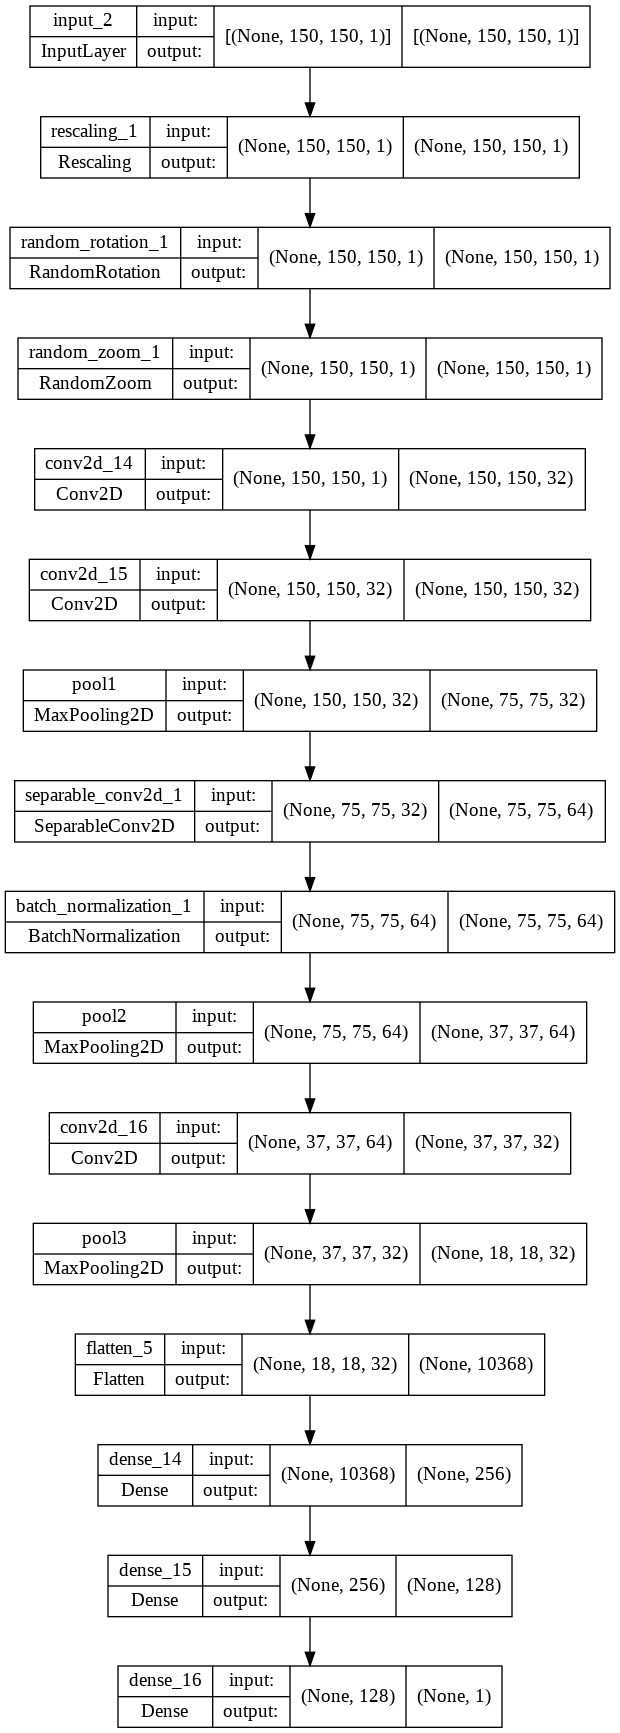

In [34]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

#Introducing first SeparableConv2D and BatchNormalization to our modeling
    x = layers.SeparableConv2D(64, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x) 
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)


    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)   
    x = Dense(128, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model1 = make_model(input_shape=(image_size) + (1,), num_classes=2)
#Showing the models steps
keras.utils.plot_model(model1, show_shapes=True)

In [35]:
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 1)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 150, 150, 1)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 150, 150, 1)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 conv2d_15 (Conv2D)          (None, 150, 150, 32)      9248      
                                                           

In [37]:
#Model checkpoint monitor val_loss and save best model
#Setting log directory and using tensoboard callback so our data can be uploaded to Tensorboard 
#Similar to above, uncoment the below rows to save checkpoints and load data to TensorBoard

# mod_checkpt = ModelCheckpoint(filepath ="/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/my_model1.h5",monitor= "val_loss", save_best_only=True )
#log_dir = "/content/drive/MyDrive/Colab Notebooks/Diagnosing-Pneumonia_CNN/Models/logs fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Using early stop to stop model after 10 epochs of no improvenment
early_stop = EarlyStopping(monitor= "val_loss", mode="min", patience = 10, restore_best_weights=True)
lr_rate = ReduceLROnPlateau(monitor="val_loss", patience=5, factor=.000000001)
callbacks = [early_stop, lr_rate]

In [38]:
model1.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result1 = model1.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 72s 698ms/step - loss: 0.4269 - accuracy: 0.8140 - recall_5: 0.9443 - val_loss: 0.6048 - val_accuracy: 0.7476 - val_recall_5: 1.0000 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 72s 704ms/step - loss: 0.2672 - accuracy: 0.8839 - recall_5: 0.9303 - val_loss: 0.5670 - val_accuracy: 0.7238 - val_recall_5: 1.0000 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 78s 769ms/step - loss: 0.2135 - accuracy: 0.9116 - recall_5: 0.9429 - val_loss: 0.5728 - val_accuracy: 0.7238 - val_recall_5: 1.0000 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 76s 749ms/step - loss: 0.1850 - accuracy: 0.9313 - recall_5: 0.9518 - val_loss: 0.4536 - val_accuracy: 0.7381 - val_recall_5: 1.0000 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 73s 717ms/step - loss: 0.1981 - accuracy: 0.9231 - recall_5: 0.9518 - val_loss: 0.4527 - val_accuracy: 0.7286 - val_recall_5: 1.0000 - lr: 0.

In [39]:
model1_eval = model_eval(model1)

13/13 [==============================] - 3s 178ms/step - loss: 0.3286 - accuracy: 0.8702 - recall_5: 0.9128
Train Loss: 0.18516117334365845, Train Accuracy: 0.9293110370635986 
 Test Loss: 0.3285715579986572, Test Accuracy: 0.870192289352417.


## Second model with SeparableConv2D

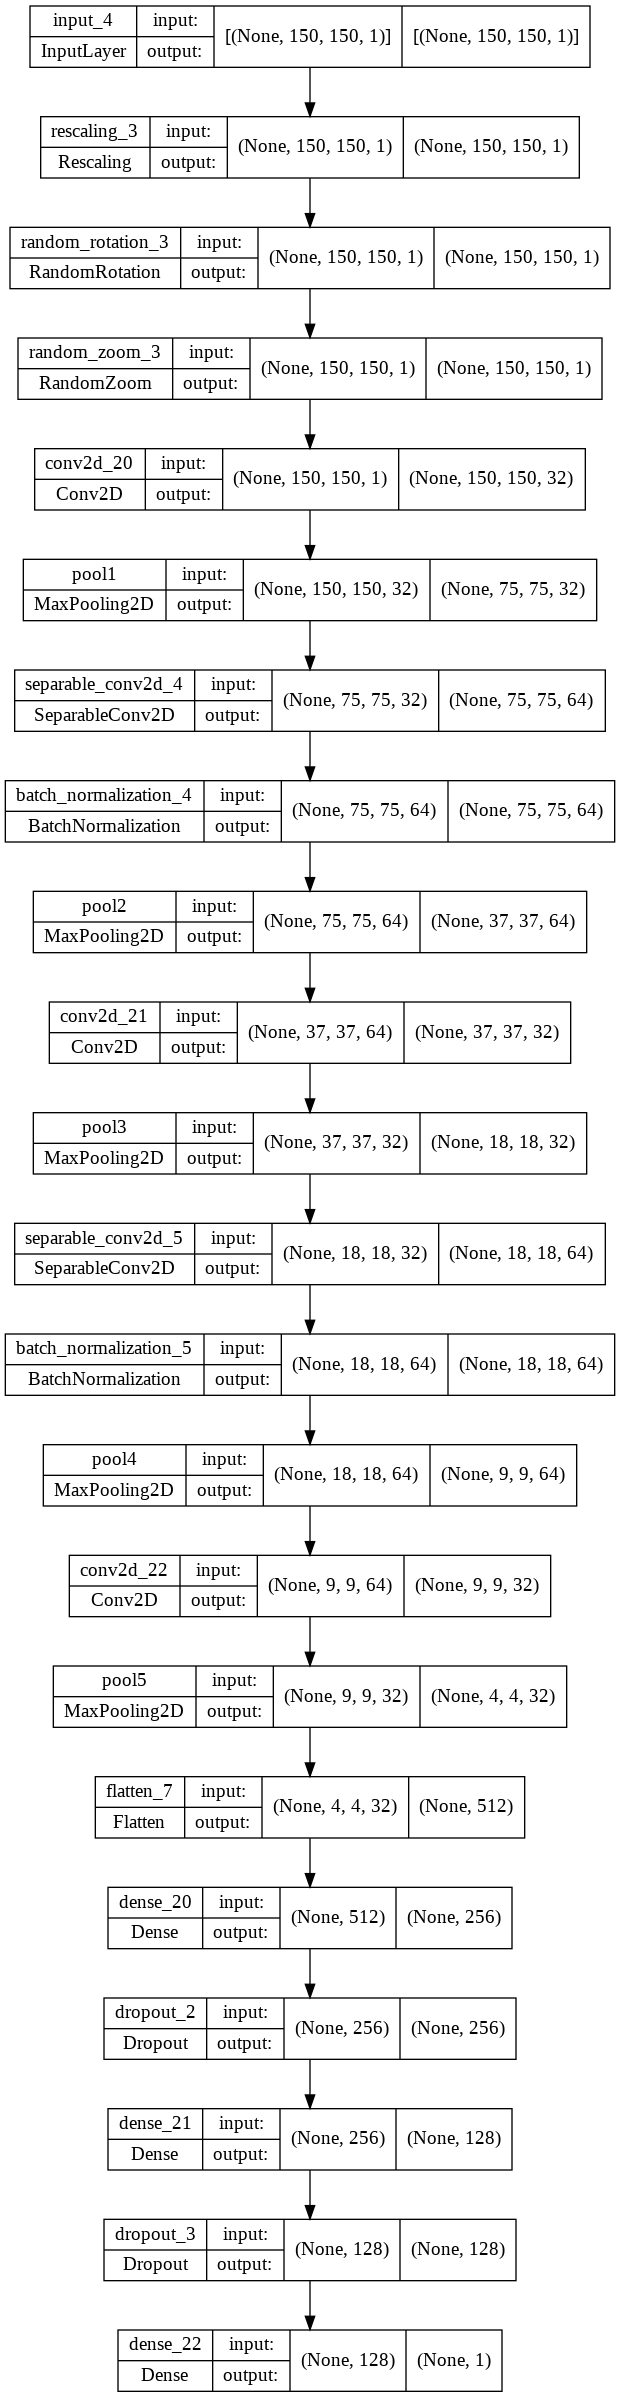

In [41]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

#Introducing first SeparableConv2D and BatchNormalization to our modeling
    x = layers.SeparableConv2D(64, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x) 
    x = MaxPooling2D((2,2), name='pool2')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = layers.SeparableConv2D(64, 3, padding="same", activation='relu')(x)
    x = layers.BatchNormalization()(x) 
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool5')(x)

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)    
    x = Dense(128, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model2 = make_model(input_shape=(image_size) + (1,), num_classes=2)
#Showing the models steps
keras.utils.plot_model(model2, show_shapes=True)

In [42]:
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 150, 150, 1)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 150, 150, 1)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 150, 150, 1)       0         
                                                                 
 conv2d_20 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                           

In [43]:
model2.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result4 = model2.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 44s 412ms/step - loss: 0.3588 - accuracy: 0.8417 - recall_6: 0.9201 - val_loss: 0.5847 - val_accuracy: 0.7238 - val_recall_6: 1.0000 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 41s 396ms/step - loss: 0.2351 - accuracy: 0.9056 - recall_6: 0.9343 - val_loss: 0.6292 - val_accuracy: 0.7238 - val_recall_6: 1.0000 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 40s 394ms/step - loss: 0.2181 - accuracy: 0.9178 - recall_6: 0.9405 - val_loss: 0.8424 - val_accuracy: 0.7238 - val_recall_6: 1.0000 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 38s 367ms/step - loss: 0.2019 - accuracy: 0.9235 - recall_6: 0.9440 - val_loss: 0.7070 - val_accuracy: 0.7238 - val_recall_6: 1.0000 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 39s 383ms/step - loss: 0.2051 - accuracy: 0.9235 - recall_6: 0.9456 - val_loss: 0.3698 - val_accuracy: 0.7857 - val_recall_6: 0.9934 - lr: 0.

In [44]:
model2_eval = model_eval(model2)

13/13 [==============================] - 2s 91ms/step - loss: 0.3753 - accuracy: 0.8622 - recall_6: 0.9513
Train Loss: 0.1315443068742752, Train Accuracy: 0.9494225382804871 
 Test Loss: 0.37526577711105347, Test Accuracy: 0.8621794581413269.


## Complex model with SeparableConv2D, BatchNormalization, SeparableConv2D loop with more sizes and residuals

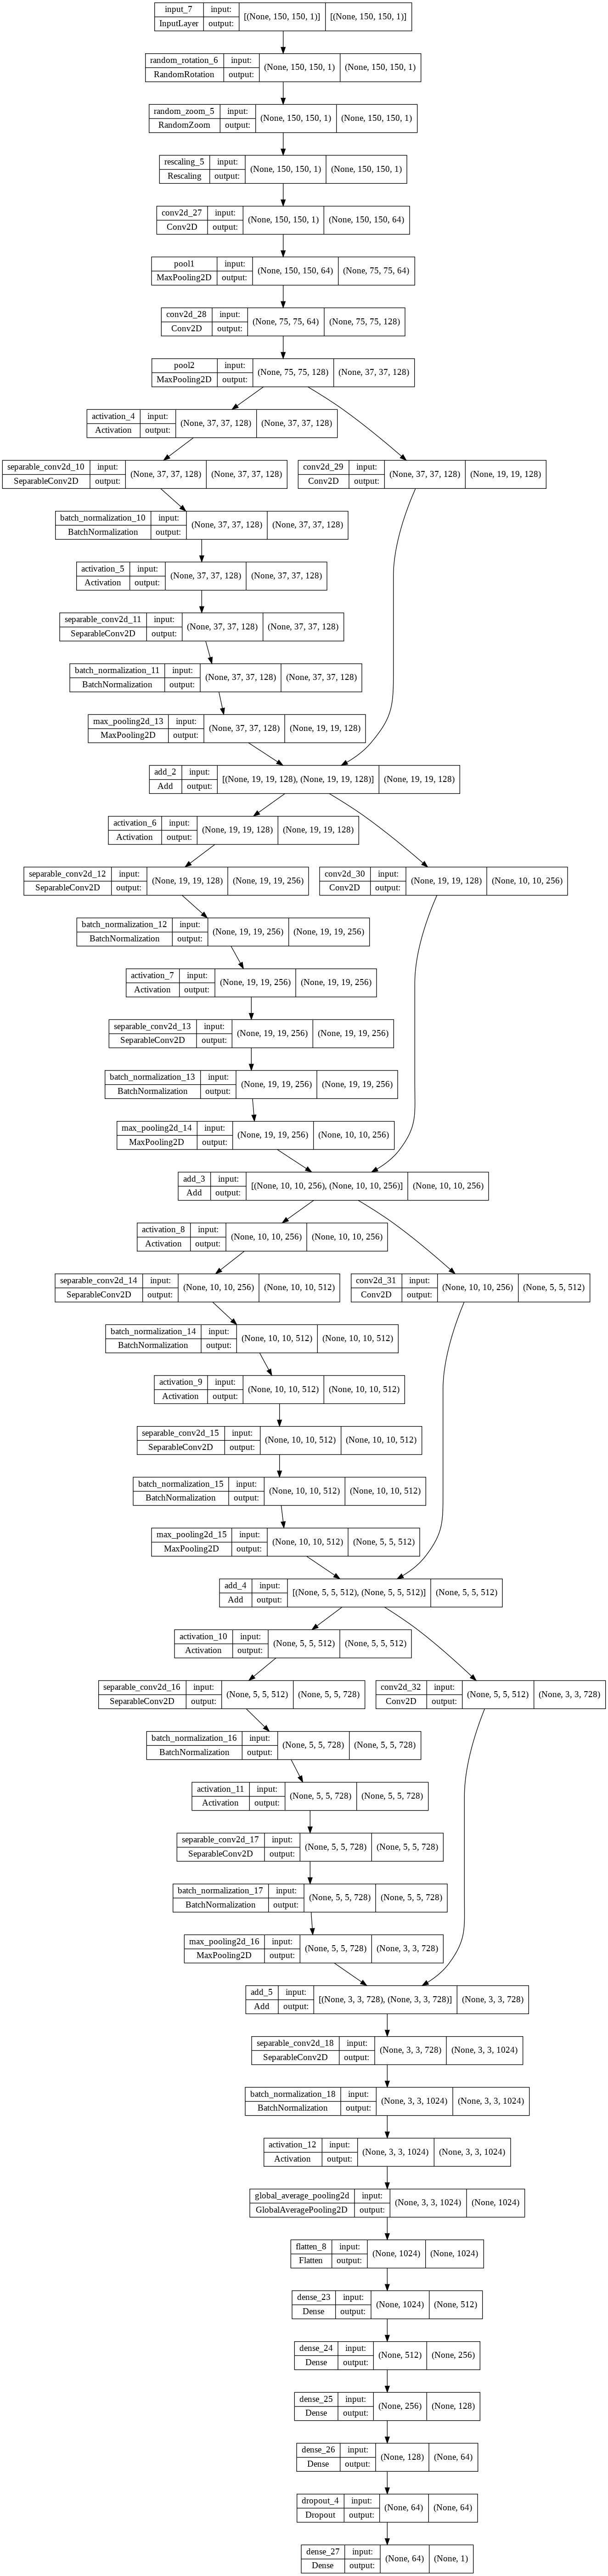

In [47]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.RandomRotation(0.6)(inputs)
    x = layers.RandomZoom(0.3)(x)


    x = layers.Rescaling(1./255)(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)


    previous_block_activation = x  # Set aside residual
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = Flatten()(x)   
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x) 
    x = Dense(64, activation='relu')(x)   

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model3 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model3, show_shapes=True)

In [48]:
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 random_rotation_6 (RandomRotat  (None, 150, 150, 1)  0          ['input_7[0][0]']                
 ion)                                                                                             
                                                                                                  
 random_zoom_5 (RandomZoom)     (None, 150, 150, 1)  0           ['random_rotation_6[0][0]']      
                                                                                            

In [49]:
model3.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result3 = model3.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 107s 1s/step - loss: 0.3356 - accuracy: 0.8548 - recall_7: 0.8896 - val_loss: 0.8936 - val_accuracy: 0.7238 - val_recall_7: 1.0000 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 100s 987ms/step - loss: 0.2704 - accuracy: 0.8923 - recall_7: 0.9145 - val_loss: 1.6017 - val_accuracy: 0.7238 - val_recall_7: 1.0000 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 102s 1s/step - loss: 0.2301 - accuracy: 0.9144 - recall_7: 0.9327 - val_loss: 2.3782 - val_accuracy: 0.7238 - val_recall_7: 1.0000 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 104s 1s/step - loss: 0.2336 - accuracy: 0.9148 - recall_7: 0.9384 - val_loss: 2.7201 - val_accuracy: 0.7238 - val_recall_7: 1.0000 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 110s 1s/step - loss: 0.2202 - accuracy: 0.9192 - recall_7: 0.9389 - val_loss: 3.1679 - val_accuracy: 0.7238 - val_recall_7: 1.0000 - lr: 0.0010
Ep

In [54]:
model3_eval = model_eval(model3)

13/13 [==============================] - 3s 229ms/step - loss: 0.3390 - accuracy: 0.8894 - recall_7: 0.9436
Train Loss: 0.1684362143278122, Train Accuracy: 0.929111897945404 
 Test Loss: 0.3390223979949951, Test Accuracy: 0.8894230723381042.


Adding SeparableConv2D is not improving our models, its adding paramaters with no gains, reverting to using Conv2d to keep paramaters low and improve processing speed

## Conv2D with Tensor 2.8

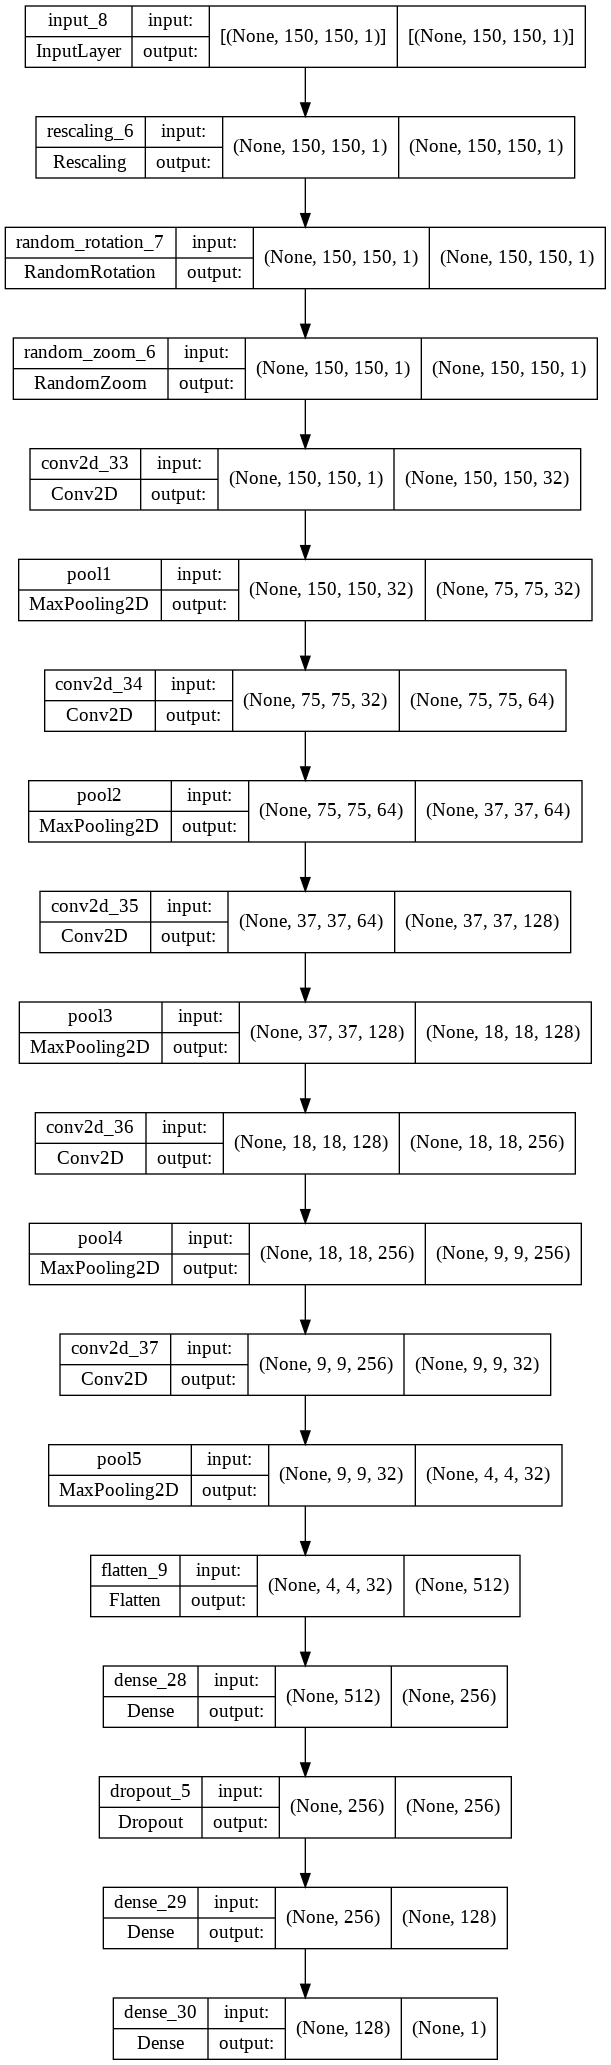

In [50]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = layers.Rescaling(1./255)(inputs)
    x = layers.RandomRotation(0.6)(x)
    x = layers.RandomZoom(0.2)(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool1')(x)

    x = Conv2D(64, 3, activation='relu', padding='same')(x)    
    x = MaxPooling2D((2,2), name='pool2')(x)    

    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)

    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)

    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2), name='pool5')(x)    

    x = Flatten()(x)   
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)    
    x = Dense(128, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model4 = make_model(input_shape=(image_size) + (1,), num_classes=2)
keras.utils.plot_model(model4, show_shapes=True)

In [51]:
model4.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 150, 150, 1)]     0         
                                                                 
 rescaling_6 (Rescaling)     (None, 150, 150, 1)       0         
                                                                 
 random_rotation_7 (RandomRo  (None, 150, 150, 1)      0         
 tation)                                                         
                                                                 
 random_zoom_6 (RandomZoom)  (None, 150, 150, 1)       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 pool1 (MaxPooling2D)        (None, 75, 75, 32)        0         
                                                           

In [52]:
model4.compile(optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.metrics.Recall()])

result_4 = model4.fit(train_ds, epochs=500, batch_size=50, validation_data=val_ds, shuffle=True, callbacks=callbacks)

Epoch 1/500
101/101 [==============================] - 56s 534ms/step - loss: 0.5870 - accuracy: 0.7397 - recall_8: 0.9928 - val_loss: 0.6039 - val_accuracy: 0.7238 - val_recall_8: 1.0000 - lr: 0.0010
Epoch 2/500
101/101 [==============================] - 55s 540ms/step - loss: 0.5767 - accuracy: 0.7429 - recall_8: 1.0000 - val_loss: 0.5849 - val_accuracy: 0.7238 - val_recall_8: 1.0000 - lr: 0.0010
Epoch 3/500
101/101 [==============================] - 55s 536ms/step - loss: 0.4723 - accuracy: 0.7714 - recall_8: 0.9485 - val_loss: 0.3260 - val_accuracy: 0.8905 - val_recall_8: 0.8618 - lr: 0.0010
Epoch 4/500
101/101 [==============================] - 55s 539ms/step - loss: 0.3774 - accuracy: 0.8280 - recall_8: 0.9091 - val_loss: 0.3849 - val_accuracy: 0.7810 - val_recall_8: 1.0000 - lr: 0.0010
Epoch 5/500
101/101 [==============================] - 54s 535ms/step - loss: 0.3374 - accuracy: 0.8497 - recall_8: 0.9129 - val_loss: 0.2607 - val_accuracy: 0.8857 - val_recall_8: 0.9276 - lr: 0.

In [53]:
model4_eval = model_eval(model4)

13/13 [==============================] - 2s 100ms/step - loss: 0.2987 - accuracy: 0.8702 - recall_8: 0.9179
Train Loss: 0.21197420358657837, Train Accuracy: 0.9109916090965271 
 Test Loss: 0.2986694574356079, Test Accuracy: 0.870192289352417.


### To see a more iterative process please use the notebooks in "modeling-notebooks"

In conclusion the model that performed best was the 4 Layer Conv2D nerural network. It produced the best results with low paramaters which will make our model faster.